In [2]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import uproot
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, TreeMakerSchema

from coffea.analysis_tools import Weights, PackedSelection

import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

ak.behavior.update(candidate.behavior)




def maskAndFill(denom,selection,value):
    numer = ak.mask(denom,selection)
    numer = ak.fill_none(numer, value) #fill none with same structure
    return ak.flatten(numer)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nCluster": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Cat("region", "region"),
                hist.Bin("nCluster", "nCluster", 4, 0, 4),
            ),                   
            "ClusterSize": hist.Hist("Events",hist.Cat("dataset", "Dataset"),   
                hist.Cat("region", "region"),
                hist.Bin("ClusterSize", "ClusterSize", 50, 0, 2000),
            ),   
            "dphi_cluster_MET": hist.Hist("Events",hist.Cat("dataset", "Dataset"),       
                hist.Cat("region", "region"),                                          
                hist.Bin("dphi_cluster_MET", r'$\Delta\phi$(cluster,MET)', 50, 0, np.pi),
            ),
            "dphi_cluster_lep": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Cat("region", "region"),                                          
                hist.Bin("dphi", r'$\Delta\phi$(cluster,lep)', 50, 0, np.pi),
            ),         
            "metXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Cat("region", "region"),                                   
                hist.Bin("metXYCorr", "metXYCorr", 50, 0, 500),
            ),
            "MT": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Cat("region", "region"),                            
                hist.Bin("MT", "MT", 50, 0, 200),
            ),            
            
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']        
        
        start,stop = events._branchargs['entry_start'],events._branchargs['entry_stop']
        events = uproot.lazy(events._tree)
        events = events[start:stop]
                
        isSignal= ak.any(events.gLLP_csc)        
        isData = not(ak.any(events.gParticleE) or ak.any(events.gLepE))
        if isSignal:        
            csc = ak.any(events.gLLP_csc,axis=1)
            events = events[(csc==1)]        
                                
        llp=ak.zip({
            'pt':events.gLLP_pt,
            'EMfrac':events.gLLP_EMFracE,
            'e':events.gLLP_e,
            'z':events.gLLP_decay_vertex_z ,
            'r':events.gLLP_decay_vertex_r,
        })  
                   
        lep=ak.zip({
            'pt':events.lepPt ,
            'eta':events.lepEta,
            'phi':events.lepPhi,
            'energy':events.lepE,
            'pdgid':events.lepPdgId,
        },with_name='PtEtaPhiELorentzVector',
        behavior=vector.behavior    
        )  
            
        ele   = lep[abs(lep.pdgid)==11]
        muons = lep[abs(lep.pdgid)==13]
        
        cluster= ak.zip(
            {                
                "time":events.cscRechitCluster3Time,
                "size":events.cscRechitCluster3Size,                
                "timeSpread":events.cscRechitCluster3TimeSpread,
                "eta":events.cscRechitCluster3Eta,
                "phi":events.cscRechitCluster3Phi,
                "x":events.cscRechitCluster3X,
                "y":events.cscRechitCluster3Y,
                "z":events.cscRechitCluster3Z,                
                'llp_x':events.cscRechitCluster3_match_gLLP_decay_x,
                'llp_y':events.cscRechitCluster3_match_gLLP_decay_y,
                'llp_z':events.cscRechitCluster3_match_gLLP_decay_z,                 
                "NChamber":events.cscRechitCluster3NChamber,
                "MaxChamber":events.cscRechitCluster3MaxChamber,
                "MaxStation":events.cscRechitCluster3MaxStation,
                "NStation10":events.cscRechitCluster3NStation10,
                "AvgStation10":events.cscRechitCluster3AvgStation10,
                "ME11_12":(events.cscRechitCluster3Me11Ratio+events.cscRechitCluster3Me12Ratio)*events.cscRechitCluster3Size,                
                "llp_match":events.cscRechitCluster3_match_gLLP,
                "RE12":events.cscRechitCluster3_match_RE12_0p4,
                "MB1seg":events.cscRechitCluster3_match_MB1Seg_0p4,
                "RB1":events.cscRechitCluster3_match_RB1_0p4,
                "dphi_cluster_MET":events.cscRechitCluster3MetXYCorr_dPhi,                
            }
        )
        muVeto=ak.zip({
            'e':events.cscRechitCluster3MuonVetoE,
            "time":events.cscRechitCluster3Time,            
            'pt':events.cscRechitCluster3MuonVetoPt,
            'phi':events.cscRechitCluster3MuonVetoPhi,
            'eta':events.cscRechitCluster3MuonVetoEta,
            'LooseIso':events.cscRechitCluster3MuonVetoLooseIso,
            'LooseId':events.cscRechitCluster3MuonVetoLooseId,    
            'TightId':events.cscRechitCluster3MuonVetoTightId,
        })      

        jetVeto=ak.zip({
            'e':events.cscRechitCluster3JetVetoE,
            'pt':events.cscRechitCluster3JetVetoPt,
            'phi':events.cscRechitCluster3JetVetoPhi,
            'eta':events.cscRechitCluster3JetVetoEta,
        })      
        
        ClusterID =((cluster.NStation10>1) & (abs(cluster.eta)<1.9))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==4) & (abs(cluster.eta)<1.8))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==3) & (abs(cluster.eta)<1.6))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==2) & (abs(cluster.eta)<1.6))
        
        muonVeto_mask = ~((muVeto.pt>20) & abs(muVeto.eta<2.4))
        jetVeto_mask  = ~((jetVeto.pt>10)& abs(jetVeto.eta<2.4))
        RE12_veto    = (cluster.RE12==0)
        MB1seg_veto  = (cluster.MB1seg==0)
        RB1_veto     = (cluster.RB1==0)
        ME11_12_veto = (cluster.ME11_12==0)

        OOT_timeCut      = (cluster.time < -12.5) #OOT for data
        IntimeCut      = (cluster.time < 12.5) & (cluster.time>-5) ## In-time otherwise        
        timeSpreadCut= (cluster.timeSpread<20)        

        selection = PackedSelection()        
        weights = Weights(len(events))
        if not isData:
            add_pileup_weight(weights, events.npv,'2018')
        
        selection.add('trigger_ele',events.SingleEleTrigger==True)
        selection.add('trigger_mu',events.SingleMuonTrigger==True)
        selection.add('MET',events.metXYCorr>30)
        selection.add('MT',events.MT>70)
        selection.add('good_electron',ak.num((ele.pt>35) & (abs(ele.eta)<2.4),axis=1)>0)
        
        cls_OOT = cluster[
            ((jetVeto_mask) &(muonVeto_mask))
            & (ME11_12_veto)
            & ((MB1seg_veto) & (RB1_veto))
            & (OOT_timeCut)
            & (timeSpreadCut)
            & (ClusterID)
        ]
        cls_inTime = cluster[
            ((jetVeto_mask) &(muonVeto_mask))
            & (ME11_12_veto)
            & ((MB1seg_veto) & (RB1_veto))
            & (IntimeCut)
            & (timeSpreadCut)
            & (ClusterID)
        ]        
        
        selection.add('cls_InTime',ak.num(cls_inTime,axis=1)>0)
        selection.add('cls_OOT',ak.num(cls_OOT,axis=1)>0)

        
        regions = {
            "ele_PreSel":['trigger_ele','MET','good_electron'],            
            "ele_SR":['trigger_ele','MET','good_electron','cls_InTime'],
            "ele_OOT":['trigger_ele','MET','good_electron','cls_OOT'],
            "noselection":[],
        }
        
        ##TODO:  build clusters from passing selections
        cluster_dir= ak.zip(
        {
                'pt':ak.ones_like(events.cscRechitCluster3Eta),
                "eta":events.cscRechitCluster3Eta,
                "phi":events.cscRechitCluster3Phi,
                'mass':ak.zeros_like(events.cscRechitCluster3Eta)
            },with_name="PtEtaPhiMLorentzVector",
            behavior=vector.behavior
        )
        
        cls_lep_pair = ak.cartesian({"cls":cluster_dir,'lep':lep},axis=1,nested=True)
        dphi_lep_cls = cls_lep_pair.cls.delta_phi(cls_lep_pair.lep)        
          
        
        output["sumw"][dataset] += len(events)
            
        for region,cuts in regions.items():
            
            cut = selection.all(*cuts)
            weight = weights.weight()[cut]
            nCluster = ak.num(cluster[cut],axis=1)
            output["nCluster"].fill(dataset=dataset,region=region,
                                    nCluster=nCluster,
                                   weight=weight)            
            output["dphi_cluster_MET"].fill(dataset=dataset,region=region,
                                           dphi_cluster_MET=np.abs(ak.flatten(cluster[cut].dphi_cluster_MET,
                                            weight=weight)))            
            output["ClusterSize"].fill(dataset=dataset,region=region,
                                        ClusterSize=ak.flatten(cluster[cut].size),
                                       weight=weight)        
            output["dphi_cluster_lep"].fill(dataset=dataset,region=region,
                                            dphi =abs(ak.flatten(dphi_lep_cls[cut],axis=None)),
                                            weight=weight
            )
            output["metXYCorr"].fill(dataset=dataset,region=region,
                                     metXYCorr=events[cut].metXYCorr,
                                    weight=weight)                    
            output["MT"].fill(dataset=dataset,region=region,
                              MT=events[cut].MT,
                             weight=weight)        

        return output

    def postprocess(self, accumulator):
        return accumulator

In [5]:
fileset = {
    r'HNL,$m_N$=5': [
        '~/eos/llp/HNL/HeavyNeutralLepton_Tree.root',
    ],
#     r'$m_s$=7,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTodddd_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_7_1000.root"
#     ],    
#     r'$m_s$=7,$c\tau$=1m': [
#         "../ggH_HToSSTodddd_v2/HeavyNeutralLepton_Tree_45_7_1000.root"
#     ],        
#     r'$m_s$=15,$c\tau$=1m': [
#         "../ggH_HToSSTodddd_v2/HeavyNeutralLepton_Tree_45_15_1000.root"
#     ],        

     'EGamma_2018A': glob.glob("/uscms/home/kkwok/lpclonglived/HNL/EGamma_2018A/HeavyNeutralLepton_Tree_*.root"),
    
#     'ZMu 2017B(t<-12.5)': [
#         "~/eos/llp/SingleMu_2017B/HeavyNeutralLepton_Tree.root"
#     ],   
#     'ZMuMu_M6000+': [
#         "~/eos/llp/ZToMuMu_NNPDF31_13TeV-powheg_M_6000_Inf/HeavyNeutralLepton_Tree.root"
#     ],   
    
    
#     r'$m_s$=15,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_15_1000.root"
#     ],    
#     'WJetsToLNu': [
#         "~/eos/llp/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/HeavyNeutralLepton_Tree.root"
#          "~/eos/llp/WJetsToLNu/HeavyNeutralLepton_Tree_0.root"        
#     ],    
      'WJetsToLNu':glob.glob("/eos/uscms/store/user/kkwok/llp/WJetsToLNu/HeavyNeutralLepton_Tree_*.root")        
    
#     r'$m_s$=40,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_1000.root"
#     ],
#     r'$m_s$=40,$c\tau$=10m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_10000.root"
#     ],    
#     r'$m_s$=55,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_55_1000.root"
#     ]    
}

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
     maxchunks=1,
     chunksize=100
)



Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

NameError: name 'add_pileup_weight' is not defined

Failed processing file: /eos/uscms/store/user/kkwok/llp/WJetsToLNu/HeavyNeutralLepton_Tree_9.root (0-101)

In [115]:
out


{'sumw': defaultdict_accumulator(float,
                         {'WJetsToLNu': 22389133.0,
                          'EGamma_2018A': 22198219.0,
                          'HNL,$m_N$=5': 4416.0}),
 'nCluster': <Hist (dataset,region,nCluster) instance at 0x7f4ea8a26c50>,
 'ClusterSize': <Hist (dataset,region,ClusterSize) instance at 0x7f4eac50dc10>,
 'dphi_cluster_MET': <Hist (dataset,region,dphi_cluster_MET) instance at 0x7f4ea958b710>,
 'dphi_cluster_lep': <Hist (dataset,region,dphi) instance at 0x7f4ea9bbd690>,
 'metXYCorr': <Hist (dataset,region,metXYCorr) instance at 0x7f4ea9b6d610>,
 'MT': <Hist (dataset,region,MT) instance at 0x7f4ea9a548d0>,
 'nPV': <Hist (dataset,region,nPV) instance at 0x7f4ea8cc9450>,
 'nPV_noweight': <Hist (dataset,region,nPV) instance at 0x7f4eabab7a90>}

In [4]:
out.keys()

dict_keys(['sumw', 'nCluster', 'ClusterSize', 'dphi_cluster_MET', 'dphi_cluster_lep', 'metXYCorr', 'MT', 'nPU', 'gWPt', 'nPU_noweight'])

In [ ]:
with open('HNL_histograms_May28.pickle','wb') as f:
    pickle.dump(out,f)

In [3]:
# with open('HNL_histograms.pickle','rb') as f:
# with open('HNL_histograms_full_2017B_WJet.pickle','rb') as f:
# with open('../HNL_histograms_May28.pickle','rb') as f:
# with open('../HNL_histograms_v3_Jun4.pickle','rb') as f:
# with open('../HNL_histograms_v3_Jun4_v2.pickle','rb') as f:
# with open('../HNL_histograms_v3_Jun10_v2.pickle','rb') as f:    
with open('../HNL_histograms_v3_Jun19.pickle','rb') as f:    
    out = pickle.load(f)

In [6]:
lumi = 0.939
br = 1
xsec = 56000*1000 *br
nevts_WJ = out['sumw']['WJetsToLNu']
nevts_data = out['sumw']['EGamma_2018A']

w_WJ = lumi * xsec / nevts_WJ
print('nevts_WJ = ',nevts_WJ )
print('nevts_data = ',nevts_data )
print('weight = ',lumi * xsec / nevts_WJ)


nevts_WJ =  22389133.0
nevts_data =  22198219.0
weight =  2.348639404661181


In [46]:
out['ClusterSize'][0:1].identifiers("dataset")

[<StringBin (EGamma_2018A) instance at 0x7f4eaba88450>]

In [125]:
out['ClusterSize'][1:,::].identifiers("region")

[<StringBin (ele_JetMuStaVeto) instance at 0x7f4ea8dfd590>,
 <StringBin (ele_JetMuVeto) instance at 0x7f4ea8dfd550>,
 <StringBin (ele_OOT) instance at 0x7f4ea8dfd610>,
 <StringBin (ele_PreSel) instance at 0x7f4ea8dfd450>,
 <StringBin (ele_SR) instance at 0x7f4ea8dfd5d0>,
 <StringBin (ele_W_CR) instance at 0x7f4ea8dfd490>,
 <StringBin (ele_W_CR2) instance at 0x7f4ea8dfd4d0>,
 <StringBin (ele_rawcls) instance at 0x7f4ea8dfd510>,
 <StringBin (noselection) instance at 0x7f4ea8dfd650>]

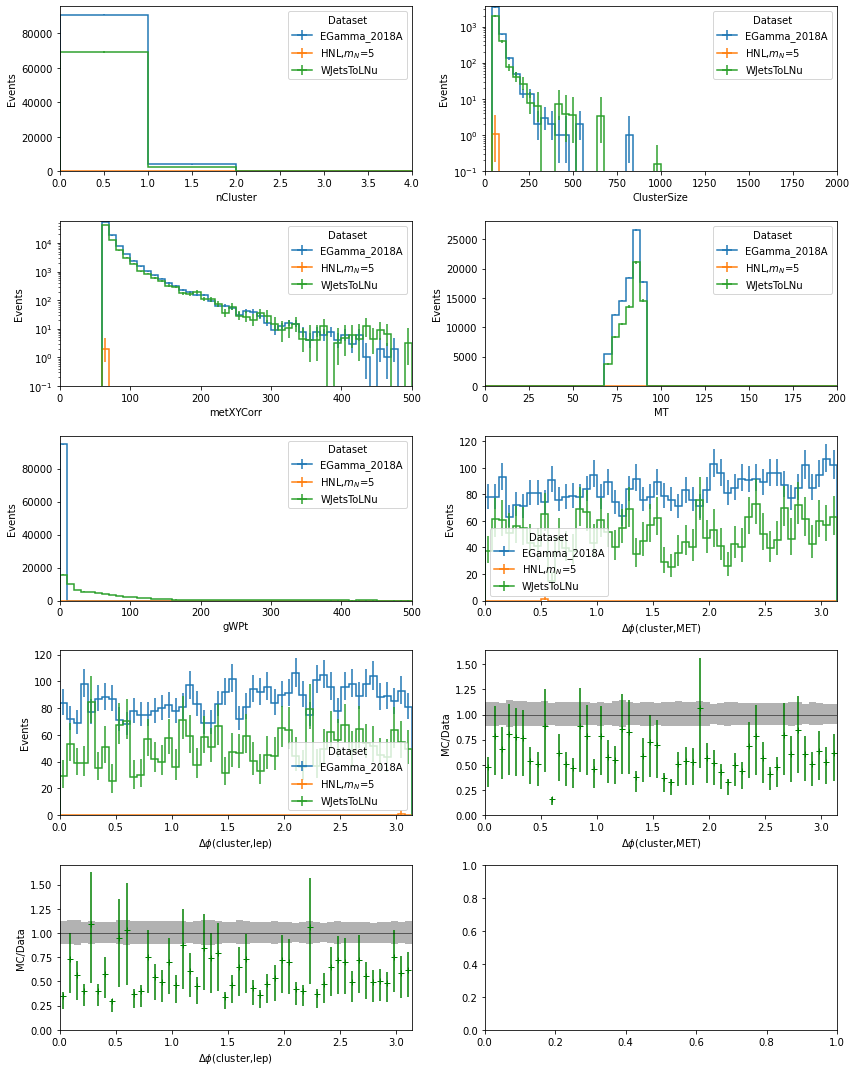

In [8]:
def ratio(p,region,ax):
    h = out[p].integrate("region",region)
    hplot = h.copy()
    hplot.scale({"WJetsToLNu": w_WJ}, "dataset")     
    d = hplot.integrate("dataset","EGamma_2018A")
    w = hplot.integrate("dataset","WJetsToLNu")

    w.label="MC/Data"
    hist.plotratio(num=w,
                   denom=d,
                   ax=ax,
                   denom_fill_opts={},
                   guide_opts={"ls":"-"},
                   error_opts={'color':"g",'marker': '+'},               
                   unc='poisson-ratio')


# regions = ['noselection','ele_W_CR','ele_PreSel','ele_OOT','ele_SR']
regions = ["ele_W_CR"]

hists=[
    'nCluster',
    'ClusterSize', 
    'metXYCorr',
    'MT',
#     "nPU",
#     "nPU_noweight",
    "gWPt",
    'dphi_cluster_MET',
    'dphi_cluster_lep',
]

hratios=[
    'dphi_cluster_MET',
    'dphi_cluster_lep',
]

ncols=2
nrows=int(np.ceil((len(hists)+len(hratios))*len(regions)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()
i=0

for p in hists:
    for j,region in enumerate(regions):
#         print(i,len(axs),region)
#         h = out['ClusterSize'].integrate("region",region)
        if "SR" in region:
            h = out[p][1:,::].integrate("region",region)    
        else:
            h = out[p].integrate("region",region)                
        hplot = h.copy()
        hplot.scale({"WJetsToLNu": w_WJ}, "dataset")     
        hist.plot1d(hplot,ax=axs[i],overlay='dataset',density=False)
#         hist.plotratio(hplot,ax=axs[i],overlay='dataset',density=False)        
        
        i=i+1

for p in hratios:
    ratio(p,region,axs[i])
    i=i+1
# ratio("dphi_cluster_lep",region,axs[1])
        
# axs[4].set_xlim(1,100)
# axs[5].set_xlim(1,100);axs[5].set_ylim(None,1E4)

axs[1].set_yscale('log');axs[1].set_ylim(1E-1,None);
axs[2].set_yscale('log');axs[2].set_ylim(1E-1,None);
plt.tight_layout()
plt.show()

In [82]:
out['dphi_cluster_MET'].identifiers('region')

[<StringBin (ele_NoVeto) instance at 0x7f4eabb25b10>,
 <StringBin (ele_OOT) instance at 0x7f4eabb25dd0>,
 <StringBin (ele_PreSel) instance at 0x7f4eabb250d0>,
 <StringBin (ele_SR) instance at 0x7f4eabb25910>,
 <StringBin (ele_W_CR) instance at 0x7f4eabb25590>,
 <StringBin (ele_rawcls) instance at 0x7f4eabb25750>,
 <StringBin (noselection) instance at 0x7f4eabb258d0>]

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:357: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3457: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/

(0.0, 2.0)

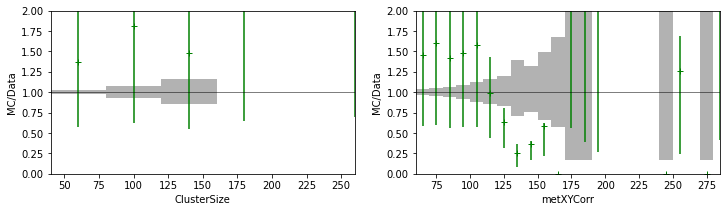

In [144]:
fig, axs = plt.subplots(1,2,figsize=(6*2,3))
axs=axs.flatten()

region='ele_JetMuStaVeto'
ratio("ClusterSize",region,axs[0])
ratio("metXYCorr",region,axs[1])
axs[0].set_ylim(0,2)
axs[1].set_ylim(0,2)
# axs[1].set_xlim(70,100)

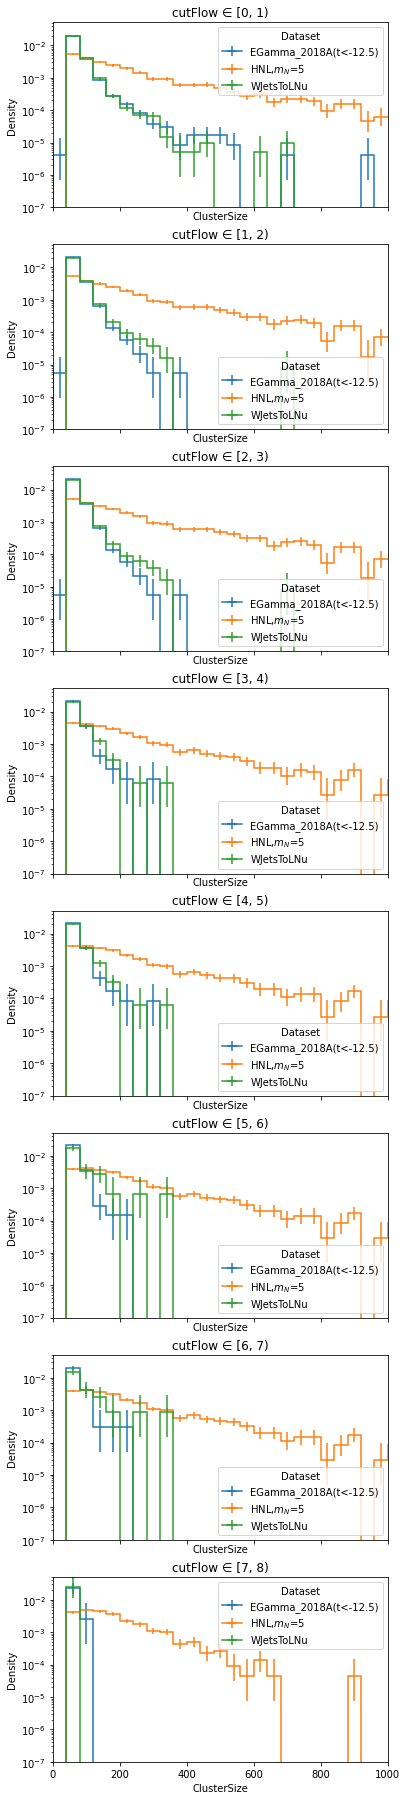

In [19]:
h = out['ClusterSize']
h.label="Density"
axs = hist.plotgrid(h,row='cutFlow',overlay='dataset',density=True)
for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_ylim(1e-7,None)
    ax.set_xlim(0,1000)

In [67]:
sig = h.integrate("dataset",["HNL,$m_N$=5"])

In [ ]:
sig.

<AxesSubplot:xlabel='$\\Delta\\phi$(cluster,MET)', ylabel='Density'>

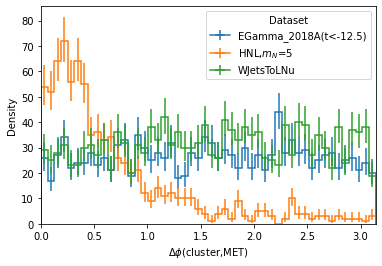

In [65]:
h = out['dphi_cluster_MET']

hist.plot1d(h.integrate("cutFlow",slice(7, None)),overlay='dataset')

<AxesSubplot:xlabel='$\\Delta\\phi$(cluster,lep)', ylabel='Events'>

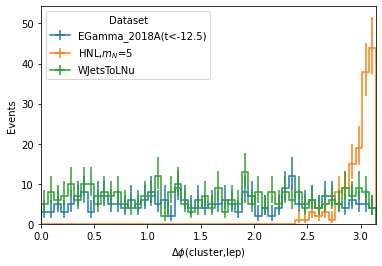

In [42]:
h = out['dphi_cluster_lep']
hist.plot1d(h.integrate("cutFlow",slice(7,None)),overlay='dataset',density=False)

<AxesSubplot:xlabel='ClusterSize', ylabel='Events'>

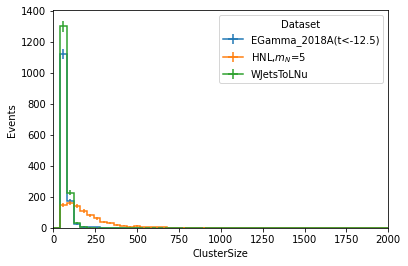

In [44]:
fig, axs = plt.subplots
h = out['ClusterSize']
hist.plot1d(h.integrate("cutFlow",slice(7,None)),overlay='dataset',density=False)

WJetsToLNu [1107183.  713644.  707167.   92650.   91682.    9919.    7354.    1557.]
[100.    64.46  63.87   8.37   8.28   0.9    0.66   0.14]
EGamma_2018A(t<-12.5) [942422. 714478. 711436.  47074.  46610.  24629.  13782.   1321.]
[100.    75.81  75.49   5.     4.95   2.61   1.46   0.14]
HNL,$m_N$=5 [2345. 2105. 2048. 1411. 1359. 1330. 1304.  825.]
[100.    89.77  87.33  60.17  57.95  56.72  55.61  35.18]


<AxesSubplot:xlabel='cutFlow', ylabel='Efficiency'>

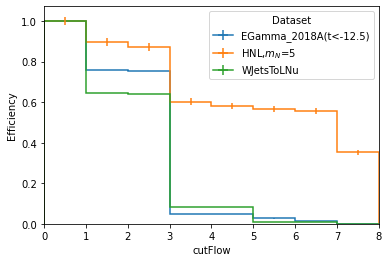

In [43]:
h = out['ClusterSize'].project('cutFlow','dataset')
h.label="Efficiency"
norm = {}
for d,cutflow in h.values().items():
    norm[d[0]]=1./cutflow[0]
    print(d[0],cutflow)
    print(np.round(cutflow/cutflow[0]*100,2))
h.scale(norm, "dataset")    
hist.plot1d(h,overlay='dataset')

In [3]:
out['sumw']

defaultdict_accumulator(float,
                        {'WJetsToLNu': 22389133.0,
                         'EGamma_2018A(t<-12.5)': 22198219.0,
                         'HNL,$m_N$=5': 4416.0})

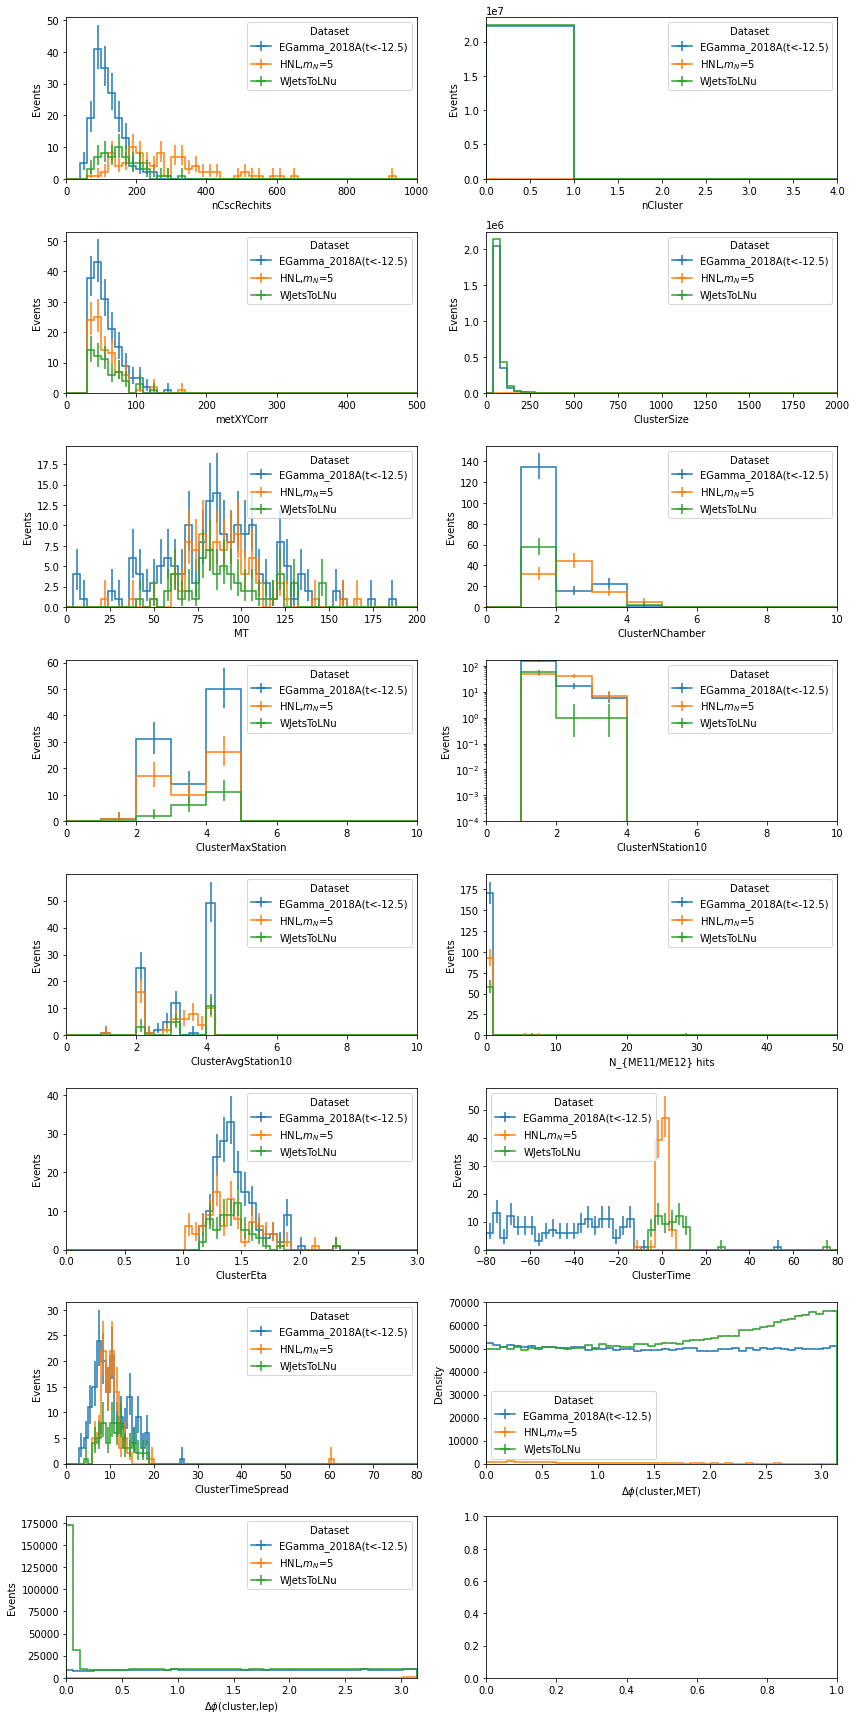

In [71]:
hists = [
    
    out["nCscRechits"],
    out["nCluster"],
    out['metXYCorr'],    
    out['ClusterSize'].project('ClusterSize','dataset'),
            out['MT'],
    out['ClusterNChamber'],
#     out['ClusterMaxChamber'],
    out['ClusterMaxStation'],
    out['ClusterNStation10'],
    out['ClusterAvgStation10'],
    out['ClusterME11_ME12'],    
    out['ClusterEta'],    
    out['ClusterTime'],
    out['ClusterTimeSpread'],
    out['dphi_cluster_MET'].project("dphi_cluster_MET","dataset"),
    out['dphi_cluster_lep'].project('dphi','dataset')

]

ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

# lumi = 4.321
# br = 0.3
# xsec = 56000*1000 *br
# nevts_WJ = out['sumw']['WJetsToLNu']
# nevts_data = out['sumw']['SingleMu 2017B(t<-12.5)']

# print('nevts_WJ = ',nevts_WJ )
# print('nevts_data = ',nevts_data )
# print('weight = ',lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
#     h.label='Density'
#     hplot = h.copy()
#     hplot.scale({"WJetsToLNu": lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ}, "dataset")    
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=False,clear=False)

# axs[2].set_ylim(1e-4,None);axs[2].set_yscale('log')    
# axs[8].set_ylim(1e-4,None);axs[8].set_yscale('log')    
axs[7].set_ylim(1e-4,None);axs[7].set_yscale('log')        

plt.tight_layout()
plt.show()

In [ ]:
h=out['clusterID']
ncols=2
nrows=2
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

hist.plot2d(h[r'HNL,$m_N$=5'].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[0])
hist.plot2d(h["SingleMu 2017B(t<-12.5)"].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[1])
hist.plot2d(h["WJetstoLNu"].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
h[r'HNL,$m_N$=5']

In [ ]:
v = out['Veto']
h = out['muVeto']
j = out['jetVeto']
ncols=2
nrows=4
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

h.label='Density'

hist.plot2d(h['SingleMu 2017B(t<-12.5)'].project("time","pt"),xaxis='time',ax=axs[0])

# for i,name in enumerate(['muVeto','jetVeto']):
#     hist.plot1d(v.project(name,'dataset'),ax=axs[i], overlay='dataset',density=True,clear=False)

# for i,name in enumerate(['pt','time','eta','LooseId','LooseIso']):
for i,name in enumerate(['pt','time','eta']):
    hist.plot1d(h.project(name,'dataset'),ax=axs[i+1], overlay='dataset',density=True,clear=False)

# for i,name in enumerate(['pt','eta']):
#     hist.plot1d(j.project(name,'dataset'),ax=axs[i+5], overlay='dataset',density=True,clear=False)

# axs[-2].set_xlabel('jetVeto_pt')    
# axs[-1].set_xlabel('jetVeto_eta')    
    
# axs[2].set_ylim(1E-4,10);axs[2].set_yscale('log')
# axs[3].set_ylim(1E-4,10);axs[3].set_yscale('log')
plt.tight_layout()
plt.show()

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:44: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:299: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:302: RuntimeWarning: invalid value encountered in multiply
  _yerr_lo[i] = _yerr_lo[i] * density_arr[i]
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/s

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:44: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:299: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/

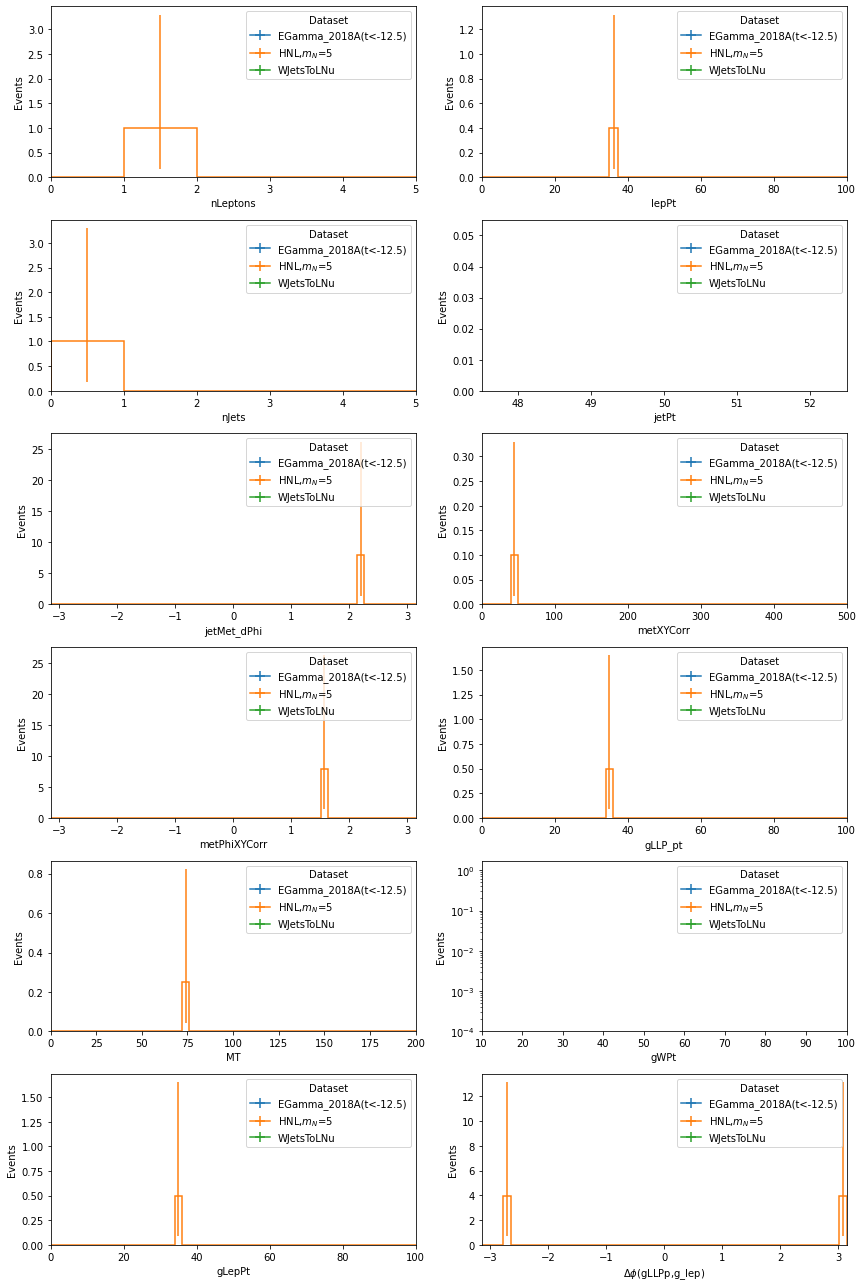

In [16]:
hists = [
    out["nLeptons"],
    out["lepPt"],
    out['nJets'],
    out['jetPt'],
    out['jetMet_dPhi'],    
    out['metXYCorr'],
    out['metPhiXYCorr'],  
    out['gLLP_pt'],
    out['MT'],    
    out['gWPt'],     
    out['gLepPt'],         
    out['glepdPhi'],             
]


ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
#     h.label='Density'
#     h.scale(, "dataset")    
#     hplot = h.copy()
#     hplot.scale({"WJetsToLNu": lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ}, "dataset")    
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)
# axs[1].set_ylim(1e3,1e7);axs[1].set_yscale('log')    
# axs[3].set_ylim(1,1e7);axs[3].set_yscale('log')
axs[9].set_ylim(1e-4,None);axs[9].set_yscale('log');axs[9].set_xlim(10,None)
# axs[4].set_ylim(1e-4,None)
# axs[4].set_yscale('log')
# axs[-3].set_ylim(1e-4,None)
# axs[-3].set_yscale('log')
plt.tight_layout()

h = out["gLLP_csc"]
ax = hist.plot1d(h, overlay='dataset',density=True,clear=False)
print("Efficiency in CSC:")
for ds,arr in h.values().items():
    print(ds,"{:.3f}".format(arr[1]/np.sum(arr)))

In [ ]:
h = out['dphi_cluster_lep']
hist.plotgrid(
    h,
    col='llp_matched',
    overlay='dataset',
    density=True,
)

In [ ]:
import matplotlib.patches as patches

def plotEff_efrac(h,ax,axis='e'):
    h_pass=h.integrate('selection',slice(1,None))
    h_pass.label='Signal Efficiency'

    h_EMfrac_p9=h.integrate("EMfrac",slice(0.5,None))
    h_EMfrac_p9_pass=h_EMfrac_p9.integrate("selection",slice(1,None))
    h_EMfrac_p9_pass.label='Signal Efficiency'
    
    h_EMfrac_low=h.integrate("EMfrac",slice(None,0.5))
    h_EMfrac_low_pass=h_EMfrac_low.integrate("selection",slice(1,None))
    h_EMfrac_low_pass.label='Signal Efficiency'
    
    hist.plotratio(
    ax=ax,
    num=h_pass.project(axis),
    denom=h.project(axis),
    error_opts={ 'marker': '.'},
    unc='clopper-pearson',
    label='Inclusive'
    )

    hist.plotratio(
        ax=ax,
        num=h_EMfrac_p9_pass.project(axis),
        denom=h_EMfrac_p9.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac>0.5'
    )
    hist.plotratio(
        ax=ax,
        num=h_EMfrac_low_pass.project(axis),
        denom=h_EMfrac_low.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac<0.5'
    )    
    ax.legend(loc='best')
    return ax

def plotEff(h_list,ax,axis='e'):
    for h in h_list:
        h_pass=h.integrate('selection',slice(1,None))
        h_pass.label='Signal Efficiency'
        
        hist.plotratio(
            ax=ax,
            num=h_pass.project(axis),
            denom=h.project(axis),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label=h.identifiers('dataset')[0].name,
            clear=False
        )

    ax.legend(loc='best')
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-110 ,y_max*0.05, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.05, "Outer ring", fontsize=15)
    return ax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

In [ ]:
h=out['llp'][2:]

ncols=2
nrows=4
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs=axs.flatten()

for i,d in enumerate(['selection','e','EMfrac','z','r']):
    hist.plot1d(h.project(d,'dataset'),ax=axs[i],overlay="dataset",density=True)

plotEff_efrac(         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5'],axs[5],'z')    
    
axs[5] = drawCSCz(axs[5])    
# plotEff([         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#          h[r'HNL,$m_N$=5'],                  
#          ],axs[5],'e')
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[6],'z')
# axs[6].set_ylim(0,2)
# axs[6] = drawCSCz(axs[6])
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[7],'r')
# axs[7] = drawCSCr(axs[7])
plt.tight_layout()

In [ ]:

h=out['llp']

ncols=1
nrows=1
figsize=(6,3)

fig, ax = plt.subplots(figsize=figsize)


plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5'],         
         ],ax,'EMfrac')
# ax=drawCSCz(ax)
ax.legend(loc=1)

plt.tight_layout()

In [ ]:
h.identifiers("dataset")

In [ ]:
for i in h:
    print(i.identifiers("dataset"))

In [ ]:
h_HNL.sparse_axes()

In [ ]:
#'clusterDecay': <Hist (dataset,length,llp_z,cluster_z) instance at 0x7f3ee4304a90>,

h = out['clusterDecay']

l =out['llp']



ncols=2
nrows=3
figsize=(6,4)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs=axs.flatten()


h_higgs = h[r'$m_s$=15,$c\tau$=1m']
h_HNL    =h[r'HNL,$m_N$=5']

for i,histo in enumerate([h_higgs,h_HNL]):
    hist.plot2d(histo.project('llp_z',"cluster_z"),xaxis='llp_z',ax=axs[2*i])
    hist.plot2d(histo.project('llp_z',"length"),xaxis='llp_z'   ,ax=axs[2*i+1])
    drawCSCsteel(axs[2*i])
    drawCSCsteel(axs[2*i+1])    
    
def drawCSCsteel(ax,hORv='v'): 
    y_max = ax.get_zlim()[1]
    if hORv=='v':
        ax.axvline(632);ax.axvline(632+39)
        ax.axvline(724);ax.axvline(724+64)
        ax.axvline(849);ax.axvline(849+62)
        ax.axvline(970);ax.axvline(970+32)
    else:
        ax.axhline(632);ax.axhline(632+39)
        ax.axhline(724);ax.axhline(724+64)
        ax.axhline(849);ax.axhline(849+62)
        ax.axhline(970);ax.axhline(970+32)   
        
    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)        
    return 
        
# hist.plot1d(h_HNL.project("length",'dataset'),ax=axs[4],overlay="dataset")    
# hist.plot1d(h_higgs.project("length",'dataset'),ax=axs[5],overlay="dataset")    

plotEff([l[r'$m_s$=15,$c\tau$=1m']],axs[4],'z')    
axs[4] = drawCSCz(axs[4])    

plotEff([l[r'HNL,$m_N$=5']],axs[5],'z')    
axs[5] = drawCSCz(axs[5])    

    
plt.tight_layout()